In [2]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def dtw_distance(series1, series2):
    series1 = np.array(series1).reshape(-1, 1)
    series2 = np.array(series2).reshape(-1, 1)
    distance, _ = fastdtw(series1, series2, dist=euclidean)
    return distance

# Пример использования
series1 = [1, 2, 3, 4, 5]
series2 = [2, 3, 3, 4]

distance = dtw_distance(series1, series2)
print(f"DTW расстояние: {distance}")

DTW расстояние: 2.0


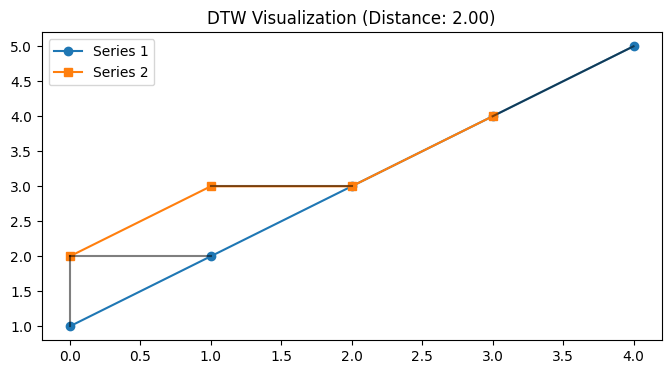

DTW расстояние: 2.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def dtw_distance(series1, series2, visualize=False):
    series1 = np.array(series1).reshape(-1, 1)
    series2 = np.array(series2).reshape(-1, 1)
    distance, path = fastdtw(series1, series2, dist=euclidean)
    
    if visualize:
        plt.figure(figsize=(8, 4))
        plt.plot(series1, label='Series 1', marker='o')
        plt.plot(series2, label='Series 2', marker='s')
        for i, j in path:
            plt.plot([i, j], [series1[i], series2[j]], 'k-', alpha=0.5)
        plt.legend()
        plt.title(f"DTW Visualization (Distance: {distance:.2f})")
        plt.show()
    
    return distance

# Пример использования
series1 = [1, 2, 3, 4, 5]
series2 = [2, 3, 3, 4]

distance = dtw_distance(series1, series2, visualize=True)
print(f"DTW расстояние: {distance}")

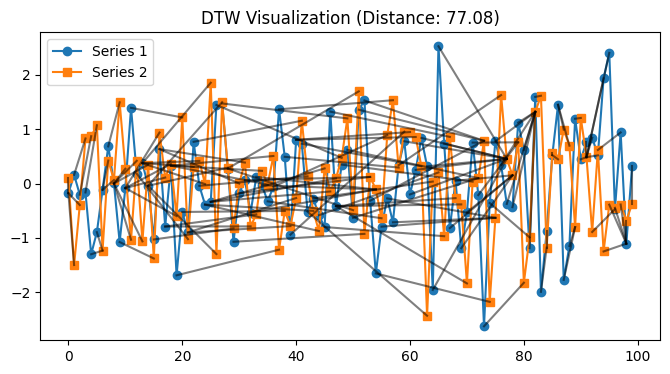

In [4]:
x = np.random.normal(0, 1, (1, 100))
y = np.random.normal(0, 1, (1, 100))

dst = dtw_distance(x, y, visualize=True)

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

from copy import deepcopy
from tqdm.notebook import tqdm
import ordpy
from scipy.stats import mode

In [2]:
def mode_with_tolerance(data):
    binned_data = np.round(np.array(data), 2)
    mode_value, _ = mode(binned_data, keepdims=False)
    return mode_value

In [3]:
def mode_with_tolerance_bins(arr, eps=0.01):
    arr = np.sort(arr)
    bucket_keys = np.floor(arr / eps) * eps
    unique_keys, counts = np.unique(bucket_keys, return_counts=True)
    largest_bucket_key = unique_keys[np.argmax(counts)]
    largest_bucket = arr[(bucket_keys >= largest_bucket_key) & 
                         (bucket_keys < largest_bucket_key + eps)]
    return np.median(largest_bucket)

In [4]:
def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return np.array([dx, dy, dz])

def get_data(p1 = 10., p2 = 28., p3 = 8/3):
    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : p1, 'ρ' : p2, 'β' : p3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T

    x = (x - min(x)) / (max(x) - min(x))
    return x

In [5]:
# Hyper params
L = 4
K = 10
eps = 0.05
beta = 1

In [6]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

train_patterns_size = int(patterns.shape[0])

In [7]:
def fit(train_data, train_points_number, start_index):
    global patterns

    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc=f"Computing matrix of Z-vectors", leave=False):
        pattern = patterns[i]
        vecs = []
        for j in range(train_points_number - pattern[-1]):
            vecs.append(train_data[pattern + j + start_index])
        z_vectors_list.append(np.array(vecs))
    return z_vectors_list

In [8]:
def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [34]:
def predict_with_demon(train_data, train_points_number, X, predicted_points_number, start, max_mape=0.05):
  global patterns, eps

  x_with_predictions = deepcopy(train_data)
  predictions = []
  for T in tqdm(range(start + train_points_number, start + train_points_number + predicted_points_number), desc="Demon predictions", leave=False):
      St = []
      for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
          normalized_predicted = norm(X[i][:, :-1] - x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]])
          St.extend(X[i][(normalized_predicted < eps), :][:, -1])
      if len(St) == 0:
         predicted_value = np.inf
      else:
         # predicted_value = mode_with_tolerance(St)
         predicted_value = mode(St, keepdims=True).mode[0]
         if abs(predicted_value - train_data[T]) / train_data[T] > max_mape:
            predicted_value = np.inf
      predictions.append(predicted_value)
      x_with_predictions[T] = predicted_value
  return predictions

In [10]:
x = get_data()
points_number = x.shape[0]

In [11]:
predicted_points_number = 50

EVERYTHING IS UNUSED

In [12]:
X = fit(x, 1000, 0)

Computing matrix of Z-vectors:   0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
arr = predict_with_demon(x, 1000, X, 50, 0)

Demon predictions:   0%|          | 0/50 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

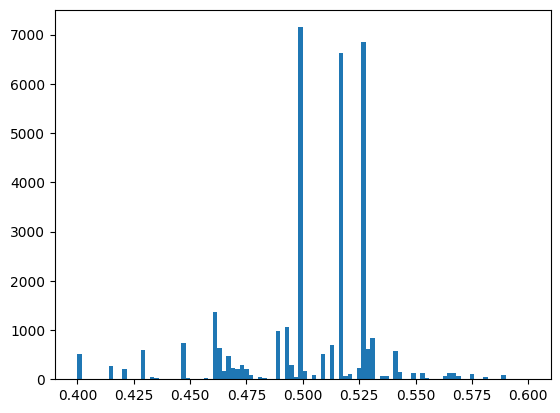

In [18]:
plt.hist(arr, bins=100, range=(0.4, 0.6))
plt.show()

In [25]:
mode(arr, keepdims=True).mode[0]

0.4992581878235369

NOW IT'S USED

In [ ]:
train_points_number = 1000
start = 9000

X1 = fit(x, train_points_number, start)

actual_vals1 = x[start + train_points_number : start + train_points_number + predicted_points_number]
predicted_vals1 = predict_with_demon(x, train_points_number, X1, predicted_points_number, start=start)

plt.plot(actual_vals1, label="Actual")
plt.plot(predicted_vals1, "o", label="Predicted")
plt.legend(loc="lower right")
plt.show()

In [ ]:
train_points_number = 2500
start = 7500

X1 = fit(x, train_points_number, start)

actual_vals1 = x[start + train_points_number : start + train_points_number + predicted_points_number]
predicted_vals1 = predict_with_demon(x, train_points_number, X1, predicted_points_number, start=start)

plt.plot(actual_vals1, label="Actual")
plt.plot(predicted_vals1, "o", label="Predicted")
plt.legend(loc="lower right")
plt.show()

In [ ]:
train_points_number = 5000
start = 5000

X1 = fit(x, train_points_number, start)

actual_vals1 = x[start + train_points_number : start + train_points_number + predicted_points_number]
predicted_vals1 = predict_with_demon(x, train_points_number, X1, predicted_points_number, start=start)

plt.plot(actual_vals1, label="Actual")
plt.plot(predicted_vals1, "o", label="Predicted")
plt.legend(loc="lower right")
plt.show()

In [29]:
def F(train_points_number):
    start = 10000 - train_points_number
    X = fit(x, train_points_number, start_index=start)

    actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
    predicted_vals = predict_with_demon(x, train_points_number, X, predicted_points_number, start=start)

    return X, actual_vals, predicted_vals

In [ ]:
train_points_number = 10000
start = 0

X = fit(x, train_points_number, start_index=start)

In [ ]:
actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
predicted_vals = predict_with_demon(x, train_points_number, X, predicted_points_number, start=start)

plt.plot(actual_vals, label="Actual")
plt.plot(predicted_vals, "o", label="Predicted")
plt.legend(loc="lower right")
plt.show()

In [32]:
data1 = F(1000)

Computing matrix of Z-vectors:   0%|          | 0/10000 [00:00<?, ?it/s]

Demon predictions:   0%|          | 0/50 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\alex\AppData\Local\Temp\ipykernel_2356\2704299061.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  predicted_value = mode(St).mode[0]


Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

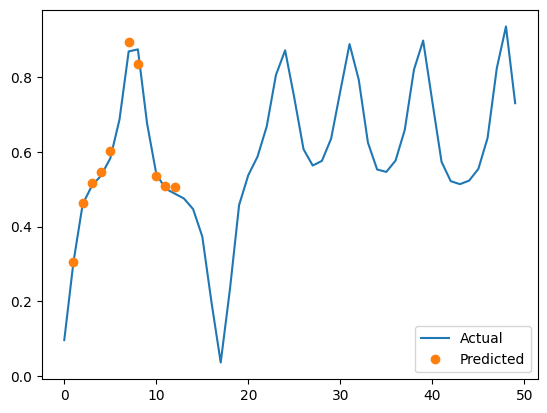

In [33]:
plt.plot(data1[1], label="Actual")
plt.plot(data1[2], "o", label="Predicted")
plt.legend(loc="lower right")
plt.show()

In [35]:
data4 = F(10000)

Computing matrix of Z-vectors:   0%|          | 0/10000 [00:00<?, ?it/s]

Demon predictions:   0%|          | 0/50 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

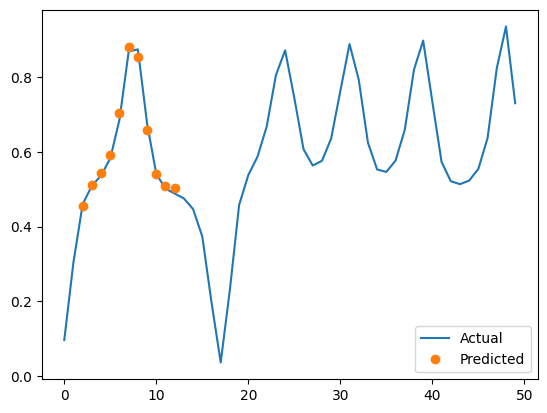

In [36]:
plt.plot(data4[1], label="Actual")
plt.plot(data4[2], "o", label="Predicted")
plt.legend(loc="lower right")
plt.show()

In [43]:
np.array(data1[2])

array([       inf, 0.30415852, 0.46375957, 0.51557737, 0.5473573 ,
       0.60284415,        inf, 0.89447702, 0.83476684,        inf,
       0.53462348, 0.50856071, 0.50516565,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf])

In [44]:
np.array(data4[2])

array([       inf,        inf, 0.45507518, 0.51150265, 0.5423039 ,
       0.59277347, 0.7036544 , 0.88040011, 0.85527893, 0.65883044,
       0.54078542, 0.50893543, 0.50316071,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf])